In [2]:

import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
random.seed( 10 ) 

In [3]:
def getSample(stringLength, testFlag=False):
    """
    Returns a random sample for bit-string addition.
    STRINGLENGTH: (int scalar) (one less than) length of the bit-string to return.
    TESTFLAG: (boolean) if True, the returned sample is printed.
    
    Returns:
        a 2-tuple of (Input,Output), where:
        INPUT: (L+1 x 2) dimensional tensor of the inputs, where L==STRINGLENGTH
        OUTPUT: (L+1) dimensional "target" vector, which is the binary sum of inputs.
    """

    lowerBound=pow(2,stringLength-1)
    upperBound=pow(2,stringLength)-1
    
    num1=random.randint(lowerBound,upperBound)
    num2=random.randint(lowerBound,upperBound)

    num3=num1+num2
    num3Binary=(bin(num3)[2:])

    num1Binary=(bin(num1)[2:])
    n=num1Binary
    num2Binary=(bin(num2)[2:])

    if testFlag==1:
        print('input numbers and their sum  are', num1, ' ', num2, ' ', num3)
        print ('binary strings are', num1Binary, ' ' , num2Binary, ' ' , num3Binary)
    len_num1= (len(num1Binary))

    len_num2= (len(num2Binary))
    len_num3= (len(num3Binary))

    # since num3 will be the largest, we pad  other numbers with zeros to that num3_len
    num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
    num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)

    # forming the input sequence
    # the input at first timestep is the least significant bits of the two input binary strings
    # x will be then a len_num3 ( or T ) * 2 array
    x=torch.zeros(len_num3,2)
    #x=np.zeros((len_num3,2),dtype=np.float32)
    for i in range(0, len_num3):
        x[i,0]=int(num1Binary[len_num3-1-i]) # note that MSB of the binray string should be the last input along the time axis
        x[i,1]=int(num2Binary[len_num3-1-i])
    #y=np.zeros((len_num3,1),dtype=np.float32)
    y=torch.zeros(len_num3,1)
    for i in range(0,len_num3):
        y[i,0]=int(num3Binary[len_num3-1-i])
    
    # target vector is the sum in binary

    return x,y

In [4]:
class Adder (nn.Module):
    def __init__(self,stateDim):
        super(Adder, self).__init__()
        self.stateDim = stateDim
        self.inputDim = 2  # two for the two inputs
        self.outputDim = 1  # one for the "score"
        # currently the model uses the 'LSTM' cell. You could try
        # others like: tanh, GRU. See: https://github.com/pytorch/examples/blob/master/word_language_model/model.py#L11
        self.lstm = nn.LSTM(self.inputDim, self.stateDim )
        self.outputLayer = nn.Linear(self.stateDim, self.outputDim)

    def forward(self, x):
        """
        X: [L,B,inputDim(=2)] dimensional input tensor
            L: Sequence length
            B: is the "batch" dimension. As we are training on 
               single examples, B = 1 for us.
        """
        lstmOut,_ = self.lstm(x)
        L,B,D  = lstmOut.size(0),lstmOut.size(1),lstmOut.size(2)
        lstmOut = lstmOut.contiguous() 
        # before  feeding to linear layer we squash one dimension
        lstmOut = lstmOut.view(L*B,D)
        pred = F.sigmoid(self.outputLayer(lstmOut)) # project lstm states to "output"
        # reshape actiavtions to T*B*outputDim
        #squeeze ll remove the extra dummy dimension for B so pred would be 2D tensor
        pred = pred.view(L,B,-1).squeeze(1) 
        return pred

In [5]:
def test_bitacc(stringLen,n_samples=100):
    n_samples = min(n_samples,2**stringLen)
    total_correctBits, total_num_bits = 0,0
    for i in range(n_samples):
        x,y = getSample(stringLen,testFlag=False)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        temp=model(x)
        temp=temp.cpu()
        finalScores =temp.data.t().numpy()
        bits = (finalScores > 0.5).astype(np.int32)
        y_pred = bits[0,:]
        #y_pred = np.transpose(y_pred)
        fullStringCorr=1
        bitsCorrectInCurrentSample=0
        for i in range (0,len(y)):
            if  y_pred[i]!=int(y[i,0]):
             
                fullStringCorr=0
            else:
                bitsCorrectInCurrentSample+=1
                total_correctBits+=1
        
        
        total_num_bits += len(y)
    accuracy = total_correctBits / (total_num_bits + 0.0)
    return accuracy

In [6]:
def test_loss(stringLen,model,n_samples=100):
    n_samples = min(n_samples,2**stringLen)
    totalLoss=0
    for i in range(n_samples):
        x,y = getSample(stringLen,testFlag=False)
        x=x.unsqueeze(1)
        pred = model(x)
        loss = lossFunction(pred,y)
        totalLoss += loss.item()
    return totalLoss/n_samples
        


Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 0.125084
[epoch 3/20] Avg. Loss for last 500 samples = 0.012028
[epoch 4/20] Avg. Loss for last 500 samples = 0.002246
[epoch 5/20] Avg. Loss for last 500 samples = 0.000097
[epoch 6/20] Avg. Loss for last 500 samples = 0.000040
[epoch 7/20] Avg. Loss for last 500 samples = 0.000657
[epoch 8/20] Avg. Loss for last 500 samples = 0.000121
[epoch 9/20] Avg. Loss for last 500 samples = 0.000770
[epoch 10/20] Avg. Loss for last 500 samples = 0.000223
[epoch 11/20] Avg. Loss for last 500 samples = 0.000313
[epoch 12/20] Avg. Loss for last 500 samples = 0.000500
[epoch 13/20] Avg. Loss for last 500 samples = 0.000088
[epoch 14/20] Avg. Loss for last 500 samples = 0.000400
[epoch 15/20] Avg. Loss for last 500 samples = 0.000285
[epoch 16/20] Avg. Loss for last 500 samples = 0.000605
[epoch 17/20] Avg. Loss for last 500 samples = 0.000030
[epoch 18/20] Avg. Loss for last 500 samples = 0.000044
[epoch 19/20] Avg. Loss for last 500 samples = 0.000142


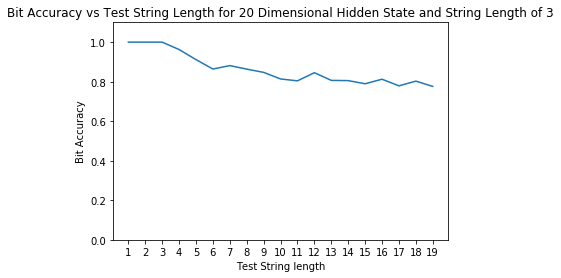

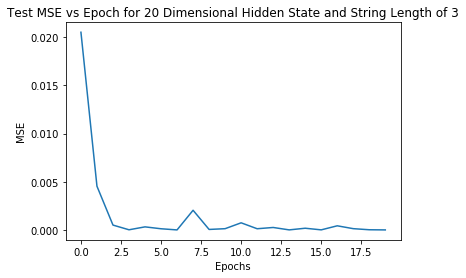

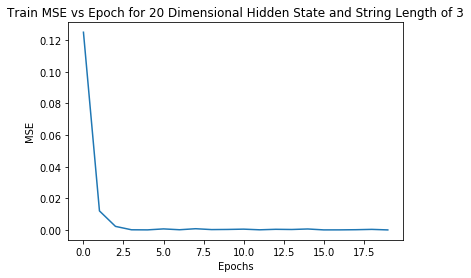

In [236]:
stateSize = 20
stringLen = 3
model = Adder(stateSize)
print ('Model initialized')

lossFunction = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
tnloss=[]
tloss=[]
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        x,y = getSample(stringLen)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        pred = model(x)
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    totalLoss=totalLoss/iterations
    tloss.append(test_loss(stringLen,model,iterations))
    tnloss.append(totalLoss)
print('Training finished!')



string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()



plt.plot(tloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Test MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()


plt.plot(tnloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Train MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 0.180710
[epoch 3/20] Avg. Loss for last 500 samples = 0.020754
[epoch 4/20] Avg. Loss for last 500 samples = 0.000437
[epoch 5/20] Avg. Loss for last 500 samples = 0.000281
[epoch 6/20] Avg. Loss for last 500 samples = 0.000401
[epoch 7/20] Avg. Loss for last 500 samples = 0.000101
[epoch 8/20] Avg. Loss for last 500 samples = 0.000268
[epoch 9/20] Avg. Loss for last 500 samples = 0.004611
[epoch 10/20] Avg. Loss for last 500 samples = 0.000179
[epoch 11/20] Avg. Loss for last 500 samples = 0.000052
[epoch 12/20] Avg. Loss for last 500 samples = 0.000095
[epoch 13/20] Avg. Loss for last 500 samples = 0.000062
[epoch 14/20] Avg. Loss for last 500 samples = 0.000066
[epoch 15/20] Avg. Loss for last 500 samples = 0.000753
[epoch 16/20] Avg. Loss for last 500 samples = 0.000045
[epoch 17/20] Avg. Loss for last 500 samples = 0.000246
[epoch 18/20] Avg. Loss for last 500 samples = 0.000185
[epoch 19/20] Avg. Loss for last 500 samples = 0.000324


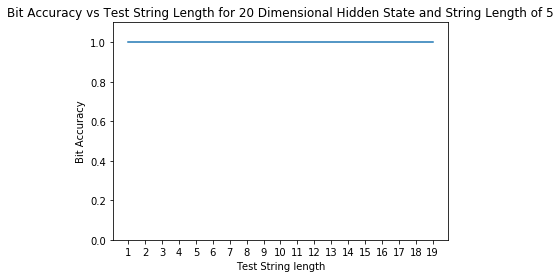

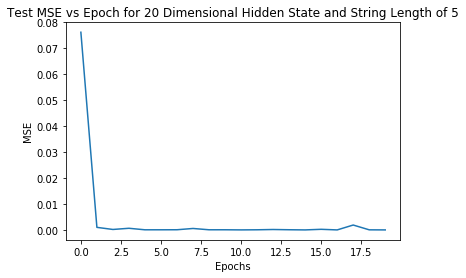

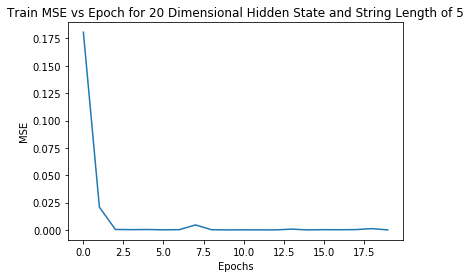

In [237]:
stateSize = 20
stringLen = 5
model = Adder(stateSize)
print ('Model initialized')

lossFunction = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
tnloss=[]
tloss=[]
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        x,y = getSample(stringLen)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        pred = model(x)
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    totalLoss=totalLoss/iterations
    tloss.append(test_loss(stringLen,model,iterations))
    tnloss.append(totalLoss)
print('Training finished!')



string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()



plt.plot(tloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Test MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()


plt.plot(tnloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Train MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 0.210567
[epoch 3/20] Avg. Loss for last 500 samples = 0.023896
[epoch 4/20] Avg. Loss for last 500 samples = 0.001010
[epoch 5/20] Avg. Loss for last 500 samples = 0.000338
[epoch 6/20] Avg. Loss for last 500 samples = 0.000173
[epoch 7/20] Avg. Loss for last 500 samples = 0.000101
[epoch 8/20] Avg. Loss for last 500 samples = 0.000066
[epoch 9/20] Avg. Loss for last 500 samples = 0.000043
[epoch 10/20] Avg. Loss for last 500 samples = 0.000031
[epoch 11/20] Avg. Loss for last 500 samples = 0.000022
[epoch 12/20] Avg. Loss for last 500 samples = 0.000016
[epoch 13/20] Avg. Loss for last 500 samples = 0.000011
[epoch 14/20] Avg. Loss for last 500 samples = 0.000009
[epoch 15/20] Avg. Loss for last 500 samples = 0.000006
[epoch 16/20] Avg. Loss for last 500 samples = 0.000005
[epoch 17/20] Avg. Loss for last 500 samples = 0.000004
[epoch 18/20] Avg. Loss for last 500 samples = 0.000003
[epoch 19/20] Avg. Loss for last 500 samples = 0.000002


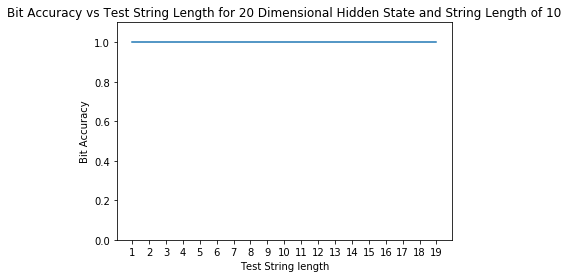

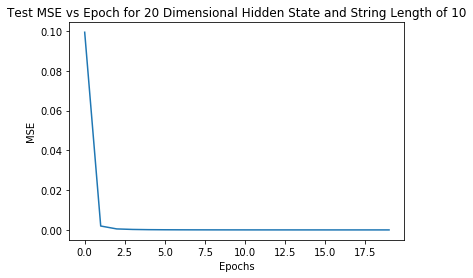

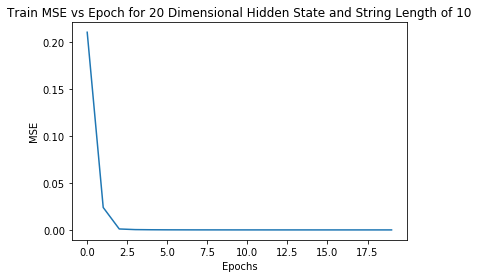

In [19]:
stateSize = 20
stringLen = 10
model = Adder(stateSize)
print ('Model initialized')

lossFunction = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
tnloss=[]
tloss=[]
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        x,y = getSample(stringLen)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        pred = model(x)
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    totalLoss=totalLoss/iterations
    tloss.append(test_loss(stringLen,model,iterations))
    tnloss.append(totalLoss)
print('Training finished!')



string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()



plt.plot(tloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Test MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()


plt.plot(tnloss)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Train MSE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/rishabh/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/rishabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 0.549988
[epoch 3/20] Avg. Loss for last 500 samples = 0.108987
[epoch 4/20] Avg. Loss for last 500 samples = 0.011810
[epoch 5/20] Avg. Loss for last 500 samples = 0.004440
[epoch 6/20] Avg. Loss for last 500 samples = 0.002222
[epoch 7/20] Avg. Loss for last 500 samples = 0.001392
[epoch 8/20] Avg. Loss for last 500 samples = 0.000852
[epoch 9/20] Avg. Loss for last 500 samples = 0.000583
[epoch 10/20] Avg. Loss for last 500 samples = 0.000389
[epoch 11/20] Avg. Loss for last 500 samples = 0.000270
[epoch 12/20] Avg. Loss for last 500 samples = 0.000205
[epoch 13/20] Avg. Loss for last 500 samples = 0.000149
[epoch 14/20] Avg. Loss for last 500 samples = 0.000108
[epoch 15/20] Avg. Loss for last 500 samples = 0.000084
[epoch 16/20] Avg. Loss for last 500 samples = 0.000062
[epoch 17/20] Avg. Loss for last 500 samples = 0.000045
[epoch 18/20] Avg. Loss for last 500 samples = 0.000034
[epoch 19/20] Avg. Loss for last 500 samples = 0.000028


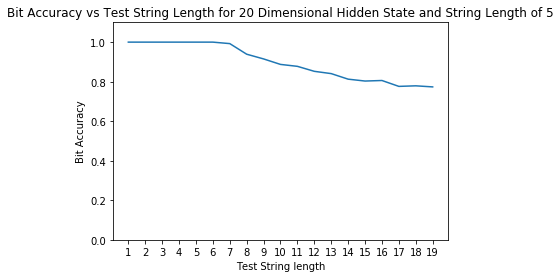

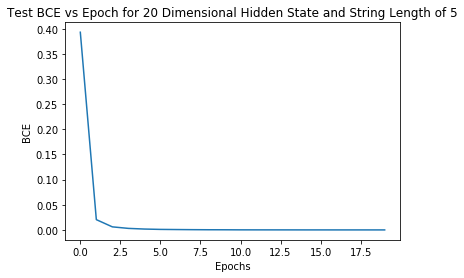

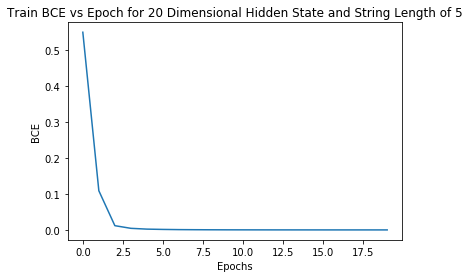

In [11]:
####CROSS-ENTROPY LOSS
stateSize = 20
stringLen = 5
model = Adder(stateSize)
print ('Model initialized')

lossFunction = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
tnloss=[]
tloss=[]
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        x,y = getSample(stringLen)
        x=x.unsqueeze(1)
        seqLen = x.size(0)
        pred = model(x)
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    totalLoss=totalLoss/iterations
    tloss.append(test_loss(stringLen,model,iterations))
    tnloss.append(totalLoss)
print('Training finished!')



string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()



plt.plot(tloss)
plt.xlabel('Epochs')
plt.ylabel('BCE')
plt.title('Test BCE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()


plt.plot(tnloss)
plt.xlabel('Epochs')
plt.ylabel('BCE')
plt.title('Train BCE vs Epoch for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()

/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


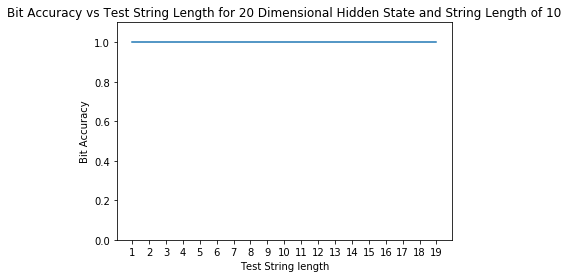

In [17]:
string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()


/home/salman/anaconda3/envs/torchworld/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


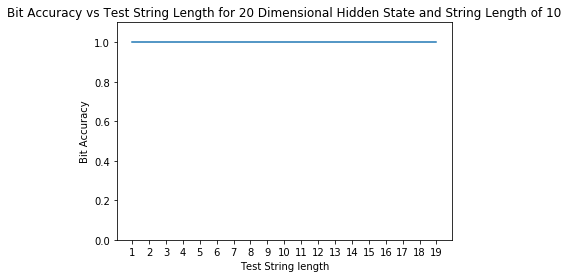

In [15]:
string_len = np.arange(1,20)
bit_accuracy = [test_bitacc(l,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('Test String length'); plt.ylabel('Bit Accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 
plt.title('Bit Accuracy vs Test String Length for '+str(stateSize)+' Dimensional Hidden State and String Length of '+str(stringLen))
plt.show()
